In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import getMolFromSmile, SmilesToDescriptors
from rdkit.Chem.AllChem import GetMorganGenerator
import seaborn as sns
#try something

In [12]:
df = pd.read_csv('dataset.csv')
df.head(2)

,reactant_1,reactant_2,reactant_3,product_R,product_S,solvent,catalyst_1,catalyst_2,product_undesired_R,product_undesired_S,ee_R,ee_S,ee_undesired_R,ee_undesired_S,yield_undesired_R,yield_undesired_S,reaction,curated_catalyst_2
0,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,0.63,-0.63,0.0,0.0,0.095598,0.094402,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C1COCCN1.F[P](F)...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...
1,c1ccc(C(=O)CBr)cc1,Cc1cccc(C)n1,C#CCCCCC=O,C#CCCC[C@H](C=O)CC(=O)c1ccccc1,C#CCCC[C@@H](C=O)CC(=O)c1ccccc1,CN(C)C=O,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,O=C[C@@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc...,O=C[C@H](CCCC1=CN(c2ccc(C(=O)OC[C@H](Cc3ccccc3...,44.66,-44.66,0.0,0.0,0.412281,0.157719,C#CCCCCC=O.c1ccc(C(=O)CBr)cc1>C[Si](C)(C)OC(c1...,F[P-](F)(F)(F)(F)F.CC(C)(C)C1=CC[N@H+]2C(=C1)C...


In [13]:
df['ee_R'].quantile(0.99)

np.float64(74.10400077819826)

In [14]:
reactant_1_pool = df['reactant_1'].unique()
catalyst_1_pool = df['catalyst_1'].unique()
catalyst_2_pool = df['catalyst_2'].unique()

print(f'Total combination count: {len(reactant_1_pool) * len(catalyst_1_pool) * len(catalyst_2_pool)} (size of the dataset:{len(df)})')

Total combination count: 1430 (size of the dataset:1430)


In [15]:
reactant_1_descriptors = SmilesToDescriptors(reactant_1_pool, method='Morgan')
catalyst_1_descriptors = SmilesToDescriptors(catalyst_1_pool, method='Morgan')
catalyst_2_descriptors = SmilesToDescriptors(catalyst_2_pool, method='Morgan', sanitize=False)

reactant_1_descriptors.head(3)

,33,46,64,90,114,125,133,136,145,175,...,799,809,816,831,841,896,904,909,940,961
c1ccc(C(=O)CBr)cc1,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
Cc1ccc(C(=O)CBr)cc1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
Oc1ccc(C(=O)CBr)cc1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
from baybe.targets import NumericalTarget
from baybe.objectives import ParetoObjective
from baybe.parameters import CustomDiscreteParameter, SubstanceParameter
from baybe.searchspace import SearchSpace

reactant_1_param = CustomDiscreteParameter(
    name='reactant_1',
    data=reactant_1_descriptors,
    decorrelate=0.7,
)

catalyst_1_param = CustomDiscreteParameter(
    name='catalyst_1',
    data=catalyst_1_descriptors,
    decorrelate=0.7,
)

catalyst_2_param = CustomDiscreteParameter(
    name='catalyst_2',
    data=catalyst_2_descriptors,
    decorrelate=0.7,
)

parameters = [
    reactant_1_param,
    catalyst_1_param,
    catalyst_2_param,
]

searchspace = SearchSpace.from_product(parameters)

target_1 = NumericalTarget(
    name="ee_R",
    mode="MAX",
)
target_2 = NumericalTarget(
    name="yield_undesired_R",
    mode="MIN",
)


objective = ParetoObjective(targets=[target_1, target_2])
lookup = df[['reactant_1', 'catalyst_1', 'catalyst_2', 'ee_R', 'yield_undesired_R']]
lookup.head(2)

#print(searchspace)

,reactant_1,catalyst_1,catalyst_2,ee_R,yield_undesired_R
0,c1ccc(C(=O)CBr)cc1,C1COCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,0.63,0.095598
1,c1ccc(C(=O)CBr)cc1,C[Si](C)(C)OC(c1ccccc1)(c1ccccc1)[C@@H]1CCCN1,F[P](F)(F)(F)(F)F.CC(C)(C)C1=CC=[N@H]2C(=C1)C3...,44.66,0.412281


In [ ]:
from baybe import Campaign
from baybe.simulation import simulate_scenarios
from baybe.recommenders import (
    BotorchRecommender,
    FPSRecommender,
    TwoPhaseMetaRecommender,
    RandomRecommender,
    )

BATCH_SIZE = 1
N_DOE_ITERATIONS = 20
N_MC_ITERATIONS = 2

botorch_fps_recommender = TwoPhaseMetaRecommender(
    initial_recommender=FPSRecommender(),  # farthest point sampling
    recommender=BotorchRecommender(),  # Bayesian model-based optimization
    switch_after=10,  # switch to Botorch after 10 iterations
    )


random_recommender = RandomRecommender()

botorch_fps_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=botorch_fps_recommender)

random_campaign = Campaign(searchspace=searchspace, objective=objective, recommender=random_recommender)

scenarios = {"Botorch FPS-Multi": botorch_fps_campaign, "Random": random_campaign}

results = simulate_scenarios(
    scenarios,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

100%|##########| 4/4 [00:31<00:00,  7.99s/it]


In [18]:
results

,Scenario,Monte_Carlo_Run,Iteration,Num_Experiments,ee_R_Measurements,yield_undesired_R_Measurements,ee_R_IterBest,ee_R_CumBest,yield_undesired_R_IterBest,yield_undesired_R_CumBest
0,Botorch FPS-Multi,0,0,1,[-8.270000457763672],[0.4815824925899505],-8.270000,-8.270000,0.481582,0.481582
1,Botorch FPS-Multi,0,1,2,[70.7699966430664],[1.3405444622039795],70.769997,70.769997,1.340544,0.481582
2,Botorch FPS-Multi,0,2,3,[-8.460000038146973],[0.064078003168106],-8.460000,70.769997,0.064078,0.064078
3,Botorch FPS-Multi,0,3,4,[44.22999954223633],[0.2163449972867965],44.230000,70.769997,0.216345,0.064078
4,Botorch FPS-Multi,0,4,5,[-10.670000076293944],[0.1339949965476989],-10.670000,70.769997,0.133995,0.064078
...,...,...,...,...,...,...,...,...,...,...
75,Random,1,15,16,[10.90999984741211],[0.0332730002701282],10.910000,69.019997,0.033273,0.027184
76,Random,1,16,17,[-61.369998931884766],[0.1738350093364715],-61.369999,69.019997,0.173835,0.027184
77,Random,1,17,18,[33.27000045776367],[0.6730135083198547],33.270000,69.019997,0.673014,0.027184
78,Random,1,18,19,[19.38999938964844],[0.1014814972877502],19.389999,69.019997,0.101481,0.027184


In [31]:
def plot_results(results, lookup, figure_name, nbr_controls=1):
  """
  Plot the results from a BayBe simulation (observations, best observations, top 99% hits and cum. regret).

  results: dataframe from the simulation
  lookup: dataframe used for the simulation
  figure_name: name of the figure to save + extension (e.g 'figure.png')
  nbr_controls: number of control campaigns
  """
  if nbr_controls < 1:
    raise ValueError('You need at least one control campaign')

  nbr_campaing = results['Scenario'].nunique()
  dashes = [(1,0)]*(nbr_campaing-nbr_controls+1) + [(3,4)]*(nbr_controls-1)

  colors = sns.color_palette('Set1', nbr_campaing-nbr_controls)
  greys = sns.color_palette('Greys', nbr_controls)[::-1]
  palette = colors + greys

  optimum = lookup['ee_R'].max()
  #add columns
  results['ins_regret'] = optimum - results['ee_R_IterBest']
  results['sim_regret'] = optimum - results['ee_R_CumBest']
  results['cum_regret'] = results.groupby(['Scenario', 'Monte_Carlo_Run'], group_keys=False)['ins_regret'].cumsum()

  optimum = lookup['yield_undesired_R'].min()
  #add columns
  results['ins_regret_yield'] = optimum - results['yield_undesired_R_IterBest']
  results['sim_regret_yield'] = optimum - results['yield_undesired_R_CumBest']
  results['cum_regret_yield'] = results.groupby(['Scenario', 'Monte_Carlo_Run'], group_keys=False)['ins_regret_yield'].cumsum()

  #Campaigns results
  iterMax = results['Iteration'].max()


  fig, ax = plt.subplots(2, 2, figsize=(10, 7))
  ax=ax.flatten()

  



  ax[0].hlines(y=lookup['ee_R'].max(), color='black', alpha=0.7, xmin=0, xmax=iterMax)
  
  sns.lineplot(data=results, x='Iteration', y='ee_R_IterBest', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[0])
  ax_2 = ax[0].twinx()
  ax_2.hlines(y=lookup['yield_undesired_R'].min(), color='blue', alpha=0.7, xmin=0, xmax=iterMax)
  sns.lineplot(data=results, x='Iteration', y='yield_undesired_R_IterBest', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax_2)
  ax_2.set_ylabel('yield_undesired_R')
  ax[0].set_ylabel('ee_R')
  ax[0].legend(fontsize=8)
  ax[0].set_title('Campaign results')


  #Cum best hit
  colors = sns.color_palette('Set1', 2)
  ax[1].hlines(y=lookup['ee_R'].max(), color='black', alpha=0.7, xmin=0, xmax=iterMax)
  sns.lineplot(data=results, x='Iteration', y='ee_R_CumBest', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[1])
  ax[1].set_title('Best hit')
  ax[1].legend(fontsize=8)
  ax[1].set_ylabel('ee_R')

  #top 99%
  ee_99 = lookup['ee_R'].quantile(0.99)
  results['top_hits'] = results.groupby(['Scenario', 'Monte_Carlo_Run'], group_keys=False)['ee_R_IterBest'] \
      .apply(lambda x: (x > ee_99).cumsum())

  sns.lineplot(data=results, x='Iteration', y='top_hits', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[2])
  ax[2].set_title('Top 99% hits')
  ax[2].set_ylabel('Number of top hits')
  ax[2].legend(fontsize=8)

  """
  sns.lineplot(data=results, x='Iteration', y='ins_regret', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[3])
  ax[3].set_title('Instantaneous regret')
  ax[3].set_ylabel('Ins. regret')
  ax[3].legend(fontsize=8)

  sns.lineplot(data=results, x='Iteration', y='sim_regret', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[4])
  ax[4].set_title('Simple regret')
  ax[4].set_ylabel('Simple regret')
  ax[4].legend(fontsize=8)
  """

  sns.lineplot(data=results, x='Iteration', y='cum_regret', hue='Scenario', style='Scenario', dashes=dashes, palette=palette, ax=ax[3])
  ax[3].set_title('Cumulative regret')
  ax[3].set_ylabel('Cum regret')
  ax[3].legend(fontsize=8)
  plt.tight_layout()
  plt.savefig('./figures/'+figure_name, dpi=300)

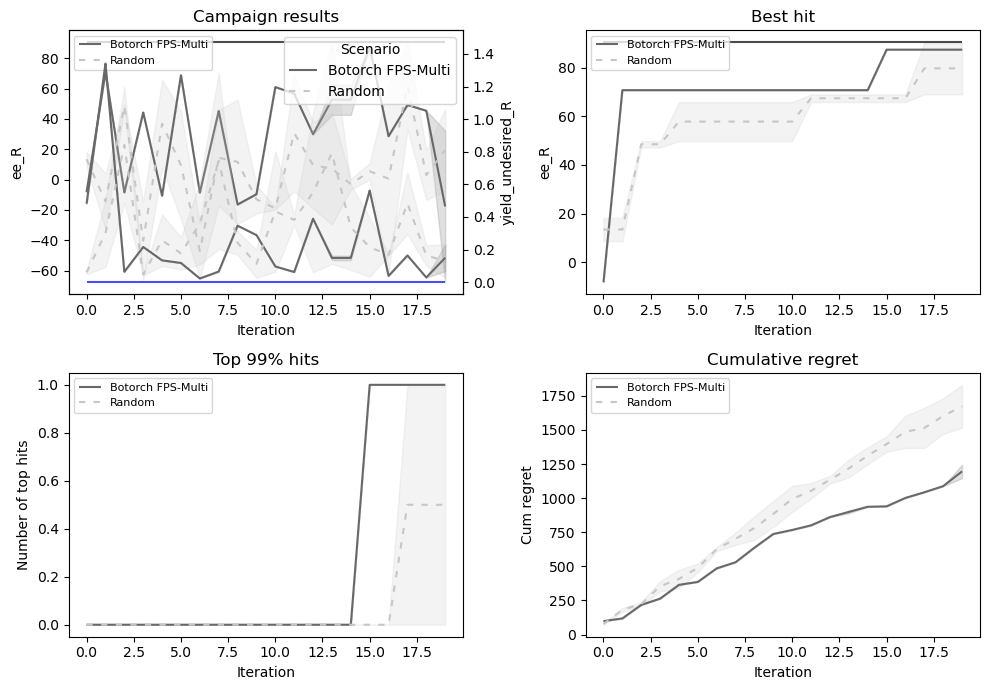

In [32]:
#from utils import plot_results

plot_results(results, lookup, figure_name= 'init_multibo.png', nbr_controls=2)
